In [1]:
import torch
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt
from diff_gaussian_rasterization import rasterize_gaussians, GaussianRasterizationSettings
import torch.nn.functional as F

In [23]:
# big
cam = {
    "id": 0,
    "img_name": "_DSC8679",
    #"width": 4946,
    "width": 800,
    #"height": 3286,
    "height": 600,
    "position": [-3.0026817933840073, 1.4007726437615275, -2.2284005560263305],
    "rotation": [
        [0.6356840663395591, -0.03804422066319289, 0.7710112872559864],
        [0.1589352827320079, 0.9838365806164537, -0.08249338484885187],
        [-0.7554107119341767, 0.17498062725643193, 0.6314558071472982]
    ],
    "fy": 4627.300372546341,
    "fx": 4649.505977743847
}
# small
# cam = {"id": 0, "img_name": "DSCF5565", "width": 3118, "height": 2078, "position": [-3.7212285514226, 1.9830705231664232, -0.2941856450880261], "rotation": [[0.45692053375530706, -0.23930622827978038, 0.8567124108703402], [0.639268405842538, 0.7580520782954387, -0.12920120697387524], [-0.6185139700316442, 0.6067038616149328, 0.49935047128967736]], "fy": 3222.7010797592447, "fx": 3222.7010797592447}
cam = {"id": 0, "img_name": "DSCF5565", "width": 800, "height": 600, "position": [-3.7212285514226, 1.9830705231664232, -0.2941856450880261], "rotation": [[0.45692053375530706, -0.23930622827978038, 0.8567124108703402], [0.639268405842538, 0.7580520782954387, -0.12920120697387524], [-0.6185139700316442, 0.6067038616149328, 0.49935047128967736]], "fy": 3222.7010797592447, "fx": 3222.7010797592447}

In [24]:
# 1. PLY 파일 로드 및 데이터 추출
ply_path = 'gs_data/point_cloud_small.ply'
plydata = PlyData.read(ply_path)
vertex_data = plydata['vertex']
# vertex_data = vertex_data[:197984]
num_points = len(vertex_data['x'])  # x 좌표의 개수를 이용하여 포인트 수 추정

def prepare_sh_coefficients_vectorized(vertex_data, num_points):
    sh_coeffs_per_point = 3 + 45  # f_dc 3개, f_rest 45개

    # f_dc 계수 추출 및 스택
    f_dc = np.stack([vertex_data[f'f_dc_{i}'] for i in range(3)], axis=-1)  # (num_points, 3)

    # f_rest 계수 추출 및 스택
    f_rest = np.stack([vertex_data[f'f_rest_{j}'] for j in range(45)], axis=-1)  # (num_points, 45)

    # f_dc와 f_rest를 결합하여 최종 SH 계수 생성
    shs = np.concatenate([f_dc, f_rest], axis=-1).astype(np.float32)  # (num_points, 48)

    # 필요에 따라 1차원 배열로 평탄화
    shs_flat = shs.reshape(-1)  # (num_points * 48,)

    return shs_flat


In [25]:
# 2. 속성 추출
vertices = np.stack([vertex_data['x'], vertex_data['y'], vertex_data['z']], axis=-1)
normals = np.stack([vertex_data['nx'], vertex_data['ny'], vertex_data['nz']], axis=-1)

shs = prepare_sh_coefficients_vectorized(vertex_data, num_points)

opacity = vertex_data['opacity']
scales = np.stack([vertex_data['scale_0'], vertex_data['scale_1'], vertex_data['scale_2']], axis=-1)
rotations = np.stack([
    vertex_data['rot_0'],
    vertex_data['rot_1'],
    vertex_data['rot_2'],
    vertex_data['rot_3']
], axis=-1)


In [26]:
# 3. PyTorch 텐서로 변환 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
means3D = torch.tensor(vertices, dtype=torch.float32).to(device)
normals_tensor = torch.tensor(normals, dtype=torch.float32).to(device)
opacity_tensor = torch.tensor(opacity, dtype=torch.float32).to(device)
scales_tensor = torch.tensor(scales, dtype=torch.float32).to(device)
rotations_tensor = torch.tensor(rotations, dtype=torch.float32).to(device)

In [27]:
def compute_camera_matrices():
    cam_pos = torch.tensor(cam["position"], dtype=torch.float32)
    rotation_matrix = torch.tensor(cam["rotation"], dtype=torch.float32)  # 3x3 행렬
    fx = cam["fx"]
    fy = cam["fy"]
    width = cam["width"]
    height = cam["height"]

    # 방향 벡터 계산
    # 여기서 rotation_matrix는 월드 좌표계에서 카메라 좌표계로의 회전 행렬이라고 가정
    # 보통 OpenGL과 DirectX는 카메라 매트릭스의 정의가 다를 수 있으니, 필요에 따라 수정
    z_axis = F.normalize(cam_pos, dim=0)  # 카메라의 방향 벡터
    x_axis = F.normalize(torch.cross(torch.tensor([0.0, 1.0, 0.0]), z_axis), dim=0)
    y_axis = torch.cross(z_axis, x_axis)

    # 뷰 매트릭스 생성
    view_matrix = torch.eye(4, dtype=torch.float32)
    view_matrix[:3, :3] = torch.stack([x_axis, y_axis, z_axis], dim=0)
    view_matrix[:3, 3] = -torch.matmul(view_matrix[:3, :3], cam_pos)

    # 투영 매트릭스 생성 (Intrinsic parameters 사용)
    near = 0.01
    far = 100.0
    proj_matrix = torch.zeros(4, 4, dtype=torch.float32)
    proj_matrix[0, 0] = 2 * fx / width
    proj_matrix[1, 1] = 2 * fy / height
    proj_matrix[2, 2] = -(far + near) / (far - near)
    proj_matrix[2, 3] = -(2 * far * near) / (far - near)
    proj_matrix[3, 2] = -1
    return view_matrix, proj_matrix

In [28]:
# 4. 래스터화 설정 정의
image_width = 800
image_height = 600

# 시야각 설정
tan_fovx = np.tan(np.radians(70))
tan_fovy = np.tan(np.radians(70))

# 카메라 매트릭스 설정
view_matrix, proj_matrix = compute_camera_matrices()

# 배경 색상 설정 (검정색)
background = torch.zeros(3, dtype=torch.float32).to(device)

degree = 3  # SH 차수

# 카메라 위치 설정
campos = torch.tensor([0.0, 0.0, 5.0], dtype=torch.float32).to(device)

# 래스터화 설정 객체 생성
raster_settings = GaussianRasterizationSettings(
    image_height=image_height,
    image_width=image_width,
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=background,
    scale_modifier=1.0,
    viewmatrix=view_matrix.contiguous().to(device),
    projmatrix=proj_matrix.contiguous().to(device),
    sh_degree=degree,
    campos=campos.contiguous(),
    prefiltered=False,
    debug=True
)

In [29]:
means2D = torch.zeros(size=(num_points, 2), device=device, dtype=torch.float32)
colors_precomp = torch.zeros((num_points, 3), device=device, dtype=torch.float32)
cov3Ds_precomp = torch.zeros((num_points, 3, 3), device=device, dtype=torch.float32)
shs = shs.reshape(num_points, 48)
shs_tensor = torch.tensor(shs, dtype=torch.float32, device=device)
print("means3D shape:", means3D.shape)
print("means2D shape:", means2D.shape)
print("sh shape:", shs_tensor.shape)
print("colors_precomp shape:", colors_precomp.shape)
print("opacities shape:", opacity_tensor.shape)
print("scales shape:", scales_tensor.shape)
print("rotations shape:", rotations_tensor.shape)
print("cov3Ds_precomp shape:", cov3Ds_precomp.shape)

color_image, radii = rasterize_gaussians(
    means3D=means3D.to(device).contiguous(),
    means2D=means2D.contiguous(),
    sh=shs_tensor.contiguous(),  # (N, 48)
    colors_precomp=colors_precomp.contiguous(), 
    opacities=opacity_tensor.to(device).contiguous(),
    scales=scales_tensor.to(device).contiguous(),
    rotations=rotations_tensor.to(device).contiguous(),
    cov3Ds_precomp=cov3Ds_precomp.contiguous(),
    raster_settings=raster_settings,
)

# 6. 결과 시각화
color_image_cpu = color_image.cpu().detach().numpy()

means3D shape: torch.Size([1157141, 3])
means2D shape: torch.Size([1157141, 2])
sh shape: torch.Size([1157141, 48])
colors_precomp shape: torch.Size([1157141, 3])
opacities shape: torch.Size([1157141])
scales shape: torch.Size([1157141, 3])
rotations shape: torch.Size([1157141, 4])
cov3Ds_precomp shape: torch.Size([1157141, 3, 3])


In [32]:
color_image_cpu_transposed = np.transpose(color_image_cpu, (1, 2, 0))
print(color_image_cpu_transposed)

[[[-4.1822376 -4.2493176 -4.1399226]
  [-4.181668  -4.248859  -4.139349 ]
  [-4.1810956 -4.2483997 -4.1387744]
  ...
  [-3.6440735 -3.7824528 -3.6028445]
  [-3.6432986 -3.7817416 -3.6020749]
  [-3.6425223 -3.7810287 -3.6013045]]

 [[-4.1818943 -4.2491264 -4.139565 ]
  [-4.181322  -4.248666  -4.1389894]
  [-4.180751  -4.248208  -4.1384153]
  ...
  [-3.6435206 -3.7820091 -3.6022804]
  [-3.6427464 -3.7812974 -3.601512 ]
  [-3.6419702 -3.7805855 -3.6007414]]

 [[-4.1815495 -4.248932  -4.139204 ]
  [-4.180978  -4.248474  -4.1386294]
  [-4.1804066 -4.248017  -4.138055 ]
  ...
  [-3.642968  -3.781565  -3.6017163]
  [-3.642192  -3.7808523 -3.600946 ]
  [-3.6414154 -3.7801385 -3.600175 ]]

 ...

 [[-3.9176652 -4.0693107 -3.8658402]
  [-3.91693   -4.068657  -3.8651063]
  [-3.916197  -4.0680013 -3.8643734]
  ...
  [-3.2545385 -3.444531  -3.20798  ]
  [-3.2536247 -3.4436345 -3.2070765]
  [-3.2527075 -3.442735  -3.2061708]]

 [[-3.9171178 -4.0688915 -3.8652775]
  [-3.9163837 -4.0682354 -3.8645442]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


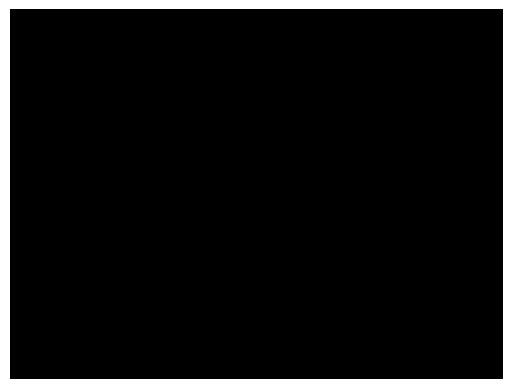

In [33]:

# Now we can display the image
plt.imshow(color_image_cpu_transposed)
plt.axis('off')  # Turns off the axis labels and ticks
plt.show()